In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import gym
import matplotlib.pyplot as plt
from gym import wrappers
from collections import deque
import random
import numpy as np
import math
import os
%matplotlib inline
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2

from gym import logger as gymlogger
from gym.wrappers import Monitor
from IPython.display import HTML
import progressbar
import glob
import io
import base64
from IPython import display as ipythondisplay
from skimage.color import rgb2gray
from skimage import transform 
# from pyvirtualdisplay import Display

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
#from keras.callbacks import TensorBoard
from keras.optimizers import Adam

from keras.callbacks import History 
hist = History()

Using TensorFlow backend.


Environment

In [ ]:
class PheonixEnvironment(gym.Env):
  def __init__(self):
    self.env = gym.make('Phoenix-v0')
    self.num_states = self.env.observation_space.shape[0]
    self.num_actions = self.env.action_space.n
    self.deque_list = deque(maxlen=10000)
    self.history = History()
    self.epsilon = 1
    self.epochs = 1
    self.gamma = 0.95
    self.episodes = 1500
    self.timesteps = 0
    self.min_memory = 500
    self.min_batch_size = 24
    self.min_epsilon = 0.001
    self.alpha = 0.001
    self.reward_threshold = 0
    self.reward_target = 5000
    self.epsilon_delta =  (self.epsilon - self.min_epsilon)/4000
    self.reward_per_episode = []
    self.epsilon_per_episode = []
    self.avg_rewards = []
    self.steps_per_episode = []
    self.timesteps_per_episode = []

    #self.env = gym.wrappers.Monitor(self.env, "recording")
    ## Keras save and load
    ## adopted from Keras training FAQs
    ## Url: https://keras.io/getting_started/faq/#how-can-i-regularly-save-keras-models-during-training
    #self.checkpoint_dir = './drive/ckpt'
    self.checkpoint_dir = F"/content/gdrive/My Drive/ddqn_pheonix_run2" 
    if not os.path.exists(self.checkpoint_dir):
        os.makedirs(self.checkpoint_dir)

    self.callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the folder name.
    keras.callbacks.ModelCheckpoint(
        filepath=self.checkpoint_dir + '/ckpt-loss={loss:.2f}', period=100)]
    ###

    self.primary_model = self.make_or_restore_model()
    self.target_model = self.make_or_restore_model()
    
    self.target_model.set_weights(self.primary_model.get_weights())
    

  ## Keras save and load
  ## method adopted from Keras training FAQs
  ## Url: https://keras.io/getting_started/faq/#how-can-i-regularly-save-keras-models-during-training
  def make_or_restore_model(self):
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [self.checkpoint_dir + '/' + name
                   for name in os.listdir(self.checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print('Restoring from', latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print('Creating a new model')
    return self.create_model()


  def reset_all(self):
    return self.env.reset()

  def preprocess(self, state):
    gray_scale = rgb2gray(state)
    cropped_frame=gray_scale[8:-12,4:-12]
    cropped_frame = cropped_frame.astype('float32')
    cropped_frame /= 255
    preprocessed_frame = transform.resize(cropped_frame, [110,84])
    return preprocessed_frame
  
  def stack_frames(self, stack_dq, state, is_new_episode):
    if is_new_episode:
      stack_dq = deque([np.zeros((4, *(110,84)))], maxlen=4)
      stack_dq.append(state)
      stack_dq.append(state)
      stack_dq.append(state)
      stack_dq.append(state)
      state = np.stack(list(stack_dq), axis=2)
    else:
      stack_dq.append(state)
      state = np.stack(list(stack_dq), axis=2)
    return state, stack_dq


  def create_model(self):
    input_shape = (110, 84, 4)
    model = Sequential()
    # model.add(Dense(24, input_dim=self.num_states, activation="relu"))
    # model.add(Dense(24, activation="relu"))
    # model.add(Dense(self.num_actions, activation="linear"))
    # model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(lr=self.alpha))   
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(self.num_actions, activation='linear')) 
    model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(lr=self.alpha))
    return model

  def choose_action(self, state, t):
    state = np.expand_dims(state, axis=0)
    if np.random.uniform(0, 1) < self.epsilon: 
      action = np.random.choice(self.num_actions)
      #print('Random action!', action)
    else: 
      values = self.primary_model.predict(state)
      action = np.argmax(values[0])
      #print('Predicted action!', action)
    return action
  
  def get_epsilon(self, e, last_reward):
    ## Implementation adapted from Reward Based Epsilon Decay
    ## Url: https://aakash94.github.io/Reward-Based-Epsilon-Decay/

    #self.epsilon = max(self.epsilon * 0.995, self.min_epsilon)
    #self.epsilon = 1 / math.log10(e + 0.00001)
    if last_reward > self.reward_threshold:    
      self.epsilon = max(self.epsilon - self.epsilon_delta, self.min_epsilon)
      self.reward_threshold = self.reward_threshold + 5

  def train_ddqn(self, sample_batch):
    for old_state, action, reward, next_state, done in sample_batch:
      old_state = np.expand_dims(old_state, axis=0)
      next_state = np.expand_dims(next_state, axis=0)
      q_val = self.primary_model.predict(old_state)
      if not done:
        target_action = np.argmax(self.target_model.predict(next_state)[0])
        q_val[0][action] = reward + (self.gamma * self.primary_model.predict(next_state)[0][target_action])
      else:
        q_val[0][action] = reward
      self.primary_model.fit(old_state, q_val, epochs=1, verbose=0, callbacks=self.callbacks)
      # print(history.history['loss'], file=open("./gdrive/My Drive/DDQN_run1/loss.txt", "a"))
      # print(history,history['accuracy'], file=open("./gdrive/My Drive/DDQN_run1/accuracy.txt", "a"))

  def analysis(self):
    print("Plotting analysis....")
    episodes = list(range(0,self.episodes))
    plt1.plot(episodes, self.reward_per_episode)
    plt1.xlabel('Episodes')
    plt1.ylabel('Rewards')
    plt1.show()

    k=0
    avg_rewards = []
    for i in range(1, int(self.episodes/100) + 1):
      avg_rewards.append(np.average(self.reward_per_episode[k:(i*100)-1]))
      k += 100

    episodes2 = [x*100 for x in range(1,int(self.episodes/100)+1)]
    print(episodes2)
    print(avg_rewards)
    plt2.plot(episodes2, avg_rewards)
    plt2.xlabel('Episodes')
    plt2.ylabel('Avg rewards')
    plt2.show()

    plt3.plot(episodes, env.epsilon_per_episode)
    plt2.xlabel('Episodes')
    plt2.ylabel('Epsilon')
    plt3.show()
    
  def execute(self):
    for episode in range(0, self.episodes): 
      print("Starting Episode: ", episode)
      stacked_frames_deque = deque([np.zeros((4, *(110,84)))], maxlen=4)
      if episode < 10 or episode > 1490: 
        self.env = wrappers.Monitor(self.env, os.path.join(F"/content/gdrive/My Drive/", "Training"), uid='episode'+str(episode), resume=False)
      old_state = self.reset_all()
      old_state = self.preprocess(old_state)
      old_state, stacked_frames_deque = self.stack_frames(stacked_frames_deque, old_state, True)
      total_reward = 0
      t = 0
      done = False
      info = {}
      last_reward = 0
      while not done:  
        action = self.choose_action(old_state, episode)
        next_state, reward, done, info = self.env.step(action)
        next_state = self.preprocess(next_state)
        next_state, stacked_frames_deque = self.stack_frames(stacked_frames_deque,next_state, False)
        if t % 100 == 0 :
          if last_reward >= total_reward:
            self.deque_list.append((old_state, action, -100, next_state, done))
          else:
            last_reward = total_reward
            self.deque_list.append((old_state, action, reward, next_state, done))
        else:
          self.deque_list.append((old_state, action, reward, next_state, done))
        
        
        old_state = next_state
        total_reward += reward
        self.timesteps += 1
        t += 1

      if episode%2 and len(self.deque_list) > self.min_batch_size:
        sample_batch = random.sample(self.deque_list, self.min_batch_size)
        self.train_ddqn(sample_batch)
      if episode%30 == 0:
        self.target_model.set_weights(self.primary_model.get_weights())

      self.reward_per_episode.append(total_reward)
      self.epsilon_per_episode.append(self.epsilon)
      self.timesteps_per_episode.append(t)
      print("Episode: ",episode," Completed with epsilon: ",self.epsilon," Timesteps in this episode: ",t,
            " Total Reward: ", total_reward," Total timesteps completed: ",self.timesteps," Additional info: ", info)
      print("Episode: ",episode," Completed with epsilon: ",self.epsilon," Timesteps in this episode: ",t,
            " Total Reward: ", total_reward," Total timesteps completed: ",self.timesteps," Additional info: ", info, file=open("./gdrive/My Drive/DDQN_run1/output.txt", "a"))
      self.get_epsilon(episode, total_reward)
      #self.history.history['loss']
      # self.show_video()

  def save_results(self):
    for i in range(self.episodes):
      print(self.reward_per_episode[i], file=open("./gdrive/My Drive/DDQN_run1/rewards_per_episode.txt", "a"))
      print(self.epsilon_per_episode[i], file=open("./gdrive/My Drive/DDQN_run1/epsilon_per_episode.txt", "a"))
      print(self.timesteps_per_episode[i], file=open("./gdrive/My Drive/DDQN_run1/timesteps_per_episode.txt", "a"))

In [ ]:
## trained with 100 episodes
env = PheonixEnvironment()
env.execute()
env.analysis()
env.save_results

Restoring from /content/gdrive/My Drive/ddqn_pheonix_run2/ckpt-loss=0.00
Restoring from /content/gdrive/My Drive/ddqn_pheonix_run2/ckpt-loss=0.00
Starting Episode:  0
Episode:  0  Completed with epsilon:  1  Timesteps in this episode:  1119  Total Reward:  500.0  Total timesteps completed:  1119  Additional info:  {'ale.lives': 0}
Starting Episode:  1
Episode:  1  Completed with epsilon:  0.99975025  Timesteps in this episode:  2073  Total Reward:  1200.0  Total timesteps completed:  3192  Additional info:  {'ale.lives': 0}
Starting Episode:  2
Episode:  2  Completed with epsilon:  0.9995004999999999  Timesteps in this episode:  662  Total Reward:  400.0  Total timesteps completed:  3854  Additional info:  {'ale.lives': 0}
Starting Episode:  3
Episode:  3  Completed with epsilon:  0.9992507499999999  Timesteps in this episode:  1027  Total Reward:  540.0  Total timesteps completed:  4881  Additional info:  {'ale.lives': 0}
Starting Episode:  4
Episode:  4  Completed with epsilon:  0.99

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (58, 105))



Episode:  1490  Completed with epsilon:  0.9068432499999819  Timesteps in this episode:  1272  Total Reward:  360.0  Total timesteps completed:  2782750  Additional info:  {'ale.lives': 0}
Starting Episode:  1491


Error: ignored

In [ ]:
episodes = list(range(0,91))
plt1.plot(episodes, env.reward_per_episode)
plt1.xlabel('episodes')
plt1.ylabel('rewards')
plt1.show()

avg_rewards_per_episode = []
k=1
episodes2 = []
for i in range(1,10):
  episodes2.append(i*10)
  avg_rewards_per_episode.append(np.average(env.reward_per_episode[k:i*10]))
  k = k+10
#print(avg_rewards_per_episode)
plt2.bar(episodes2, avg_rewards_per_episode, width=8)
plt2.xlabel('episodes')
plt2.ylabel('avg rewards')
plt2.show()

NameError: ignored

(210, 160, 3)
(210, 160)
(190, 144)
(110, 84)


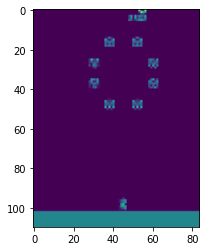

In [ ]:
env = gym.make('Phoenix-v0')
state = env.reset()
print(state.shape)
plt.imshow(state)
gray_scale = rgb2gray(state)
print(gray_scale.shape)
cropped_frame=gray_scale[8:-12,4:-12]
print(cropped_frame.shape)
cropped_frame = cropped_frame.astype('float32')
cropped_frame /= 255
preprocessed_frame = transform.resize(cropped_frame, [110,84])
print(preprocessed_frame.shape)
#env.render(state)
plt2.imshow(preprocessed_frame)

In [ ]:
print("Hello!", file=open("./gdrive/My Drive/DDQN_run1/rewards_per_episode.txt", "a"))

In [ ]:
##Trained with already loaded model for another 100 episodes
env = PheonixEnvironment()
env.execute()
env.analysis()